In [1]:
from os import *
import numpy as np
from scipy.stats import bootstrap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn import metrics
from sklearn import pipeline
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import feature_selection
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import warnings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# 2

# Start of HW4

# As in previous homework the three most important features according to me are (mean,standard deviation, median) and the the time series 1,2,6 correspond to (avg_rss12,var_rss12,var_rss23)

In [2]:
def split_dataset(data,l):
    data=np.array_split(data,l)
    initial_chunk=data[0]
    for i in range(1,len(data)):
        data[i].columns+='_'+str(i)
        initial_chunk=pd.concat([initial_chunk,data[i].reset_index(drop=True)],axis=1)
    return initial_chunk

In [3]:
def split_create_data(l,colls):
    directories=[]
    train_frames=[]
    test_frames=[]
    if(colls==0):
        columns_req=['avg_rss12','var_rss12','var_rss23']
    else:
        columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    stats_req=['mean','std','50%']
    for (dirpath, dirnames, filenames) in walk('../../data/AReM/'):
        directories.append(dirpath)
    directories=directories[1:]
    instance=1
    col_formed=[]
    train_rows=[]
    test_rows=[]
    for ii in directories:
        #print(i)
        for dirpath,dirnames,filenames in walk(ii):
            filenames=sorted(filenames)
            for i in filenames:
                data=pd.read_csv(dirpath+'/'+i,skiprows=4)
                data=data[columns_req]
                data=split_dataset(data,l)
                describe=data.describe().T[stats_req].rename({'50%':'median'},axis=1)
                row=[]
                for iii in describe.index:
                    for j in describe.columns:
                        if(len(col_formed)< (len(describe.columns)*len(describe.index))):
                            col_formed.append(iii+'_'+j)
                        row.append(describe[j][iii])
                #print(dirpath.split('/')[-1],i)
                if(dirpath.split('/')[-1] in ('bending1','bending2') and i in ('dataset1.csv','dataset2.csv')):
                    row.append('bending')
                    test_rows.append(row)
                elif(i in ('dataset1.csv','dataset2.csv','dataset3.csv') and dirpath.split('/')[-1] not in ('bending1','bending2')):
                    row.append(dirpath.split('/')[-1])
                    test_rows.append(row)
                else:
                    if(dirpath.split('/')[-1] in ('bending1','bending2')):
                        row.append('bending')
                    else:
                        row.append(dirpath.split('/')[-1])
                    train_rows.append(row)
    #print(len(test_rows))
    col_formed.append('activity')
    train_data=pd.DataFrame(columns=col_formed)
    test_data=pd.DataFrame(columns=col_formed)
    for row in train_rows:
        train_data.loc[len(train_data.index)]=row
    for row in test_rows:
        test_data.loc[len(test_data.index)]=row
    return train_data,test_data

# 2(a)i : Scatter plot for the features for no split

In [4]:
##### This function is used to convert the target into numerical binary feature wherein the value is 1 if it is bending
#### else the value is 0 for other activities
def numeric_target(data):
    #print(data.columns)
    if(data=='bending'):
        return 1
    return 0

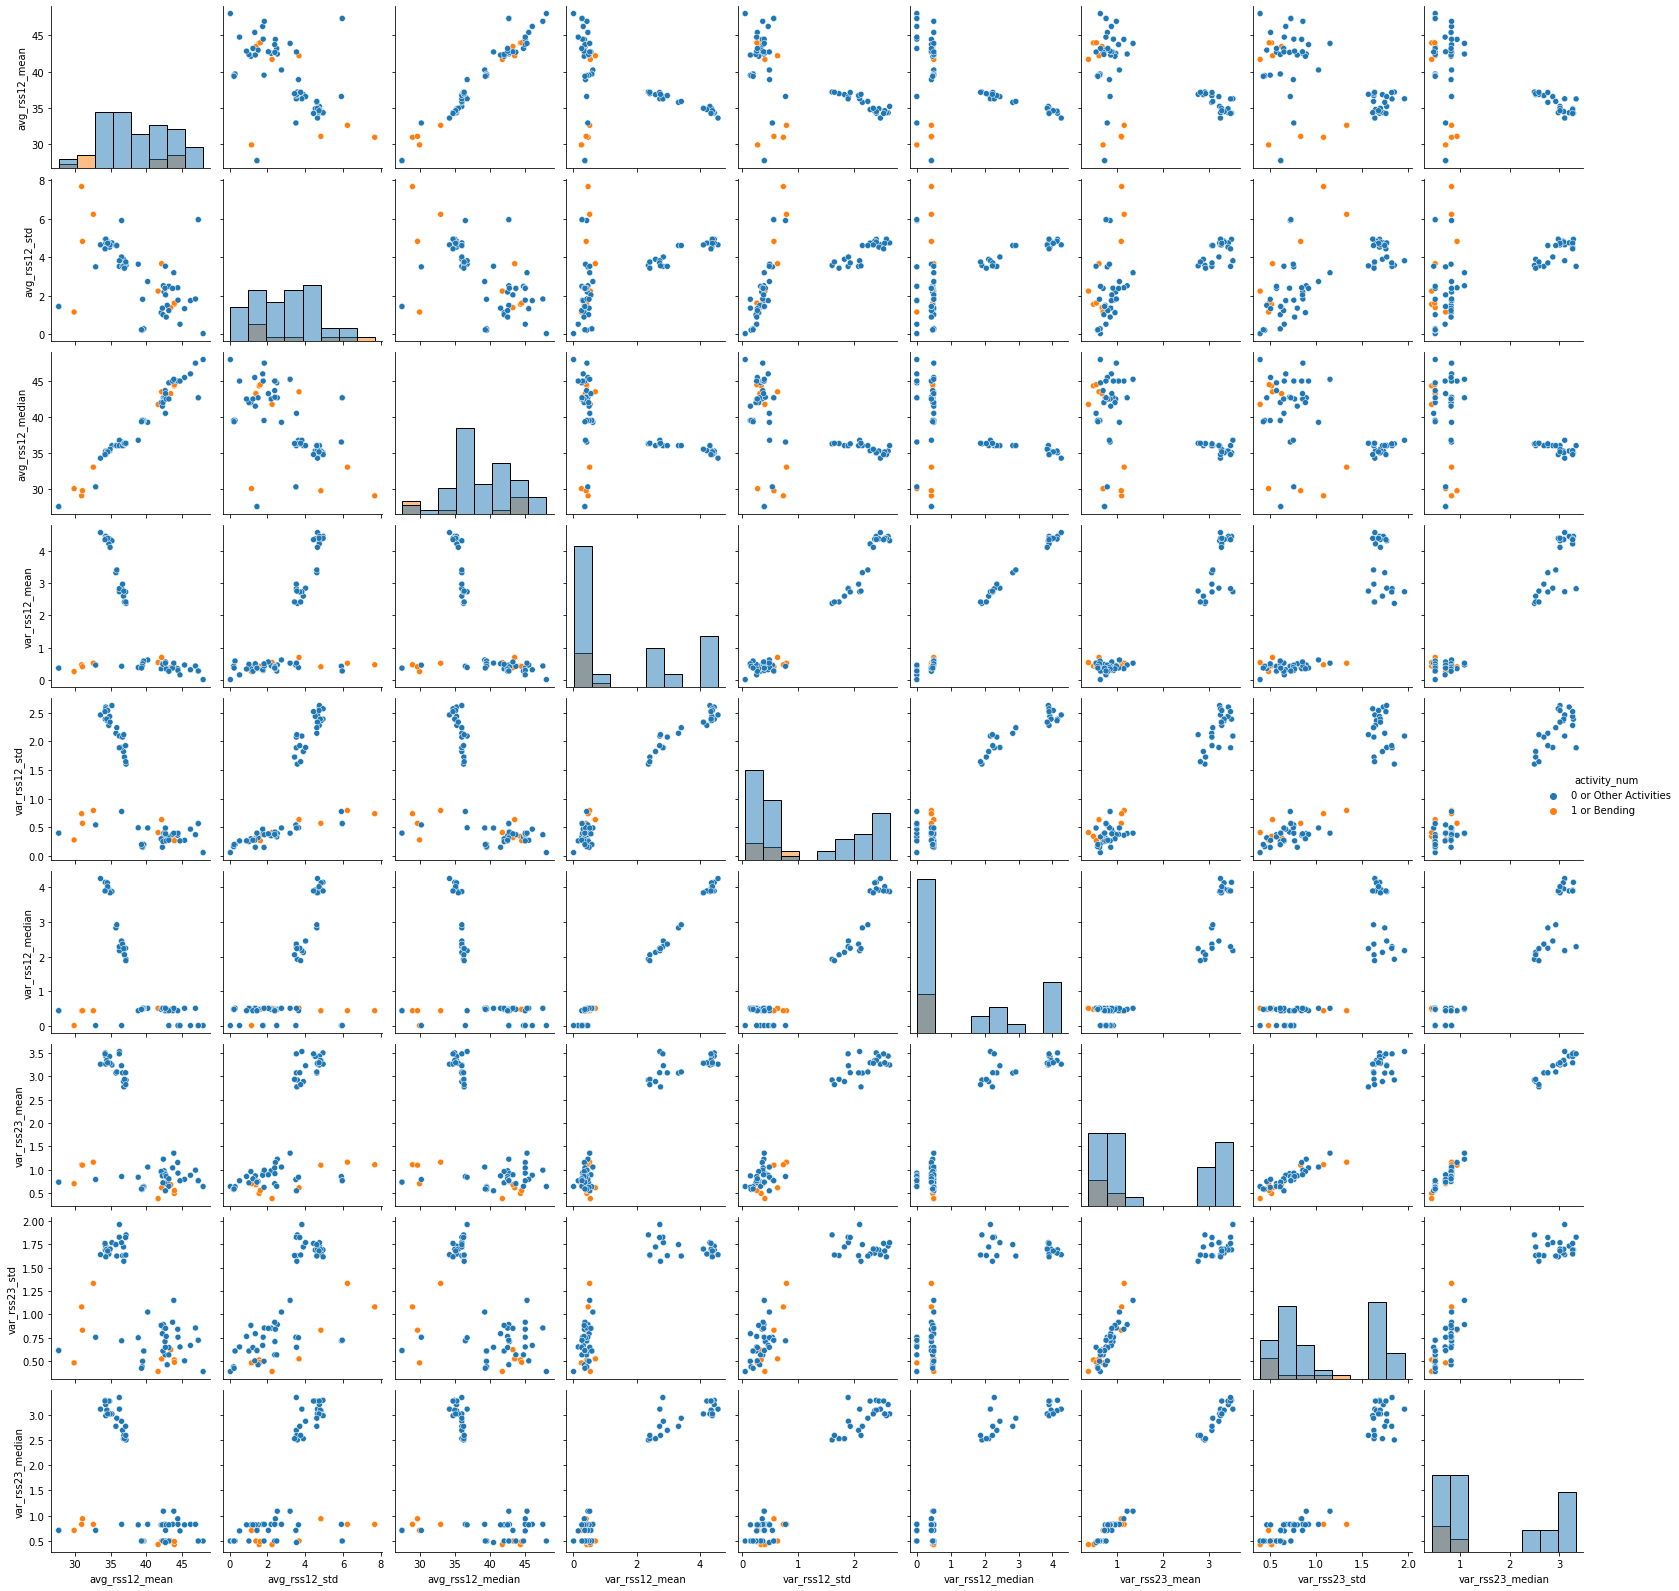

In [5]:
train_data,test_data=split_create_data(1,0)
#train_data.columns
train_data['activity_num']=train_data['activity'].apply(numeric_target)
test_data['activity_num']=test_data['activity'].apply(numeric_target)
g=sns.pairplot(train_data.drop(columns=['activity']),hue='activity_num',diag_kind='hist')
leg = g.axes.flat[0].get_legend()
new_labels = ['0 or Other Activities','1 or Bending']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# 2(a)ii : Breaking into equal parts

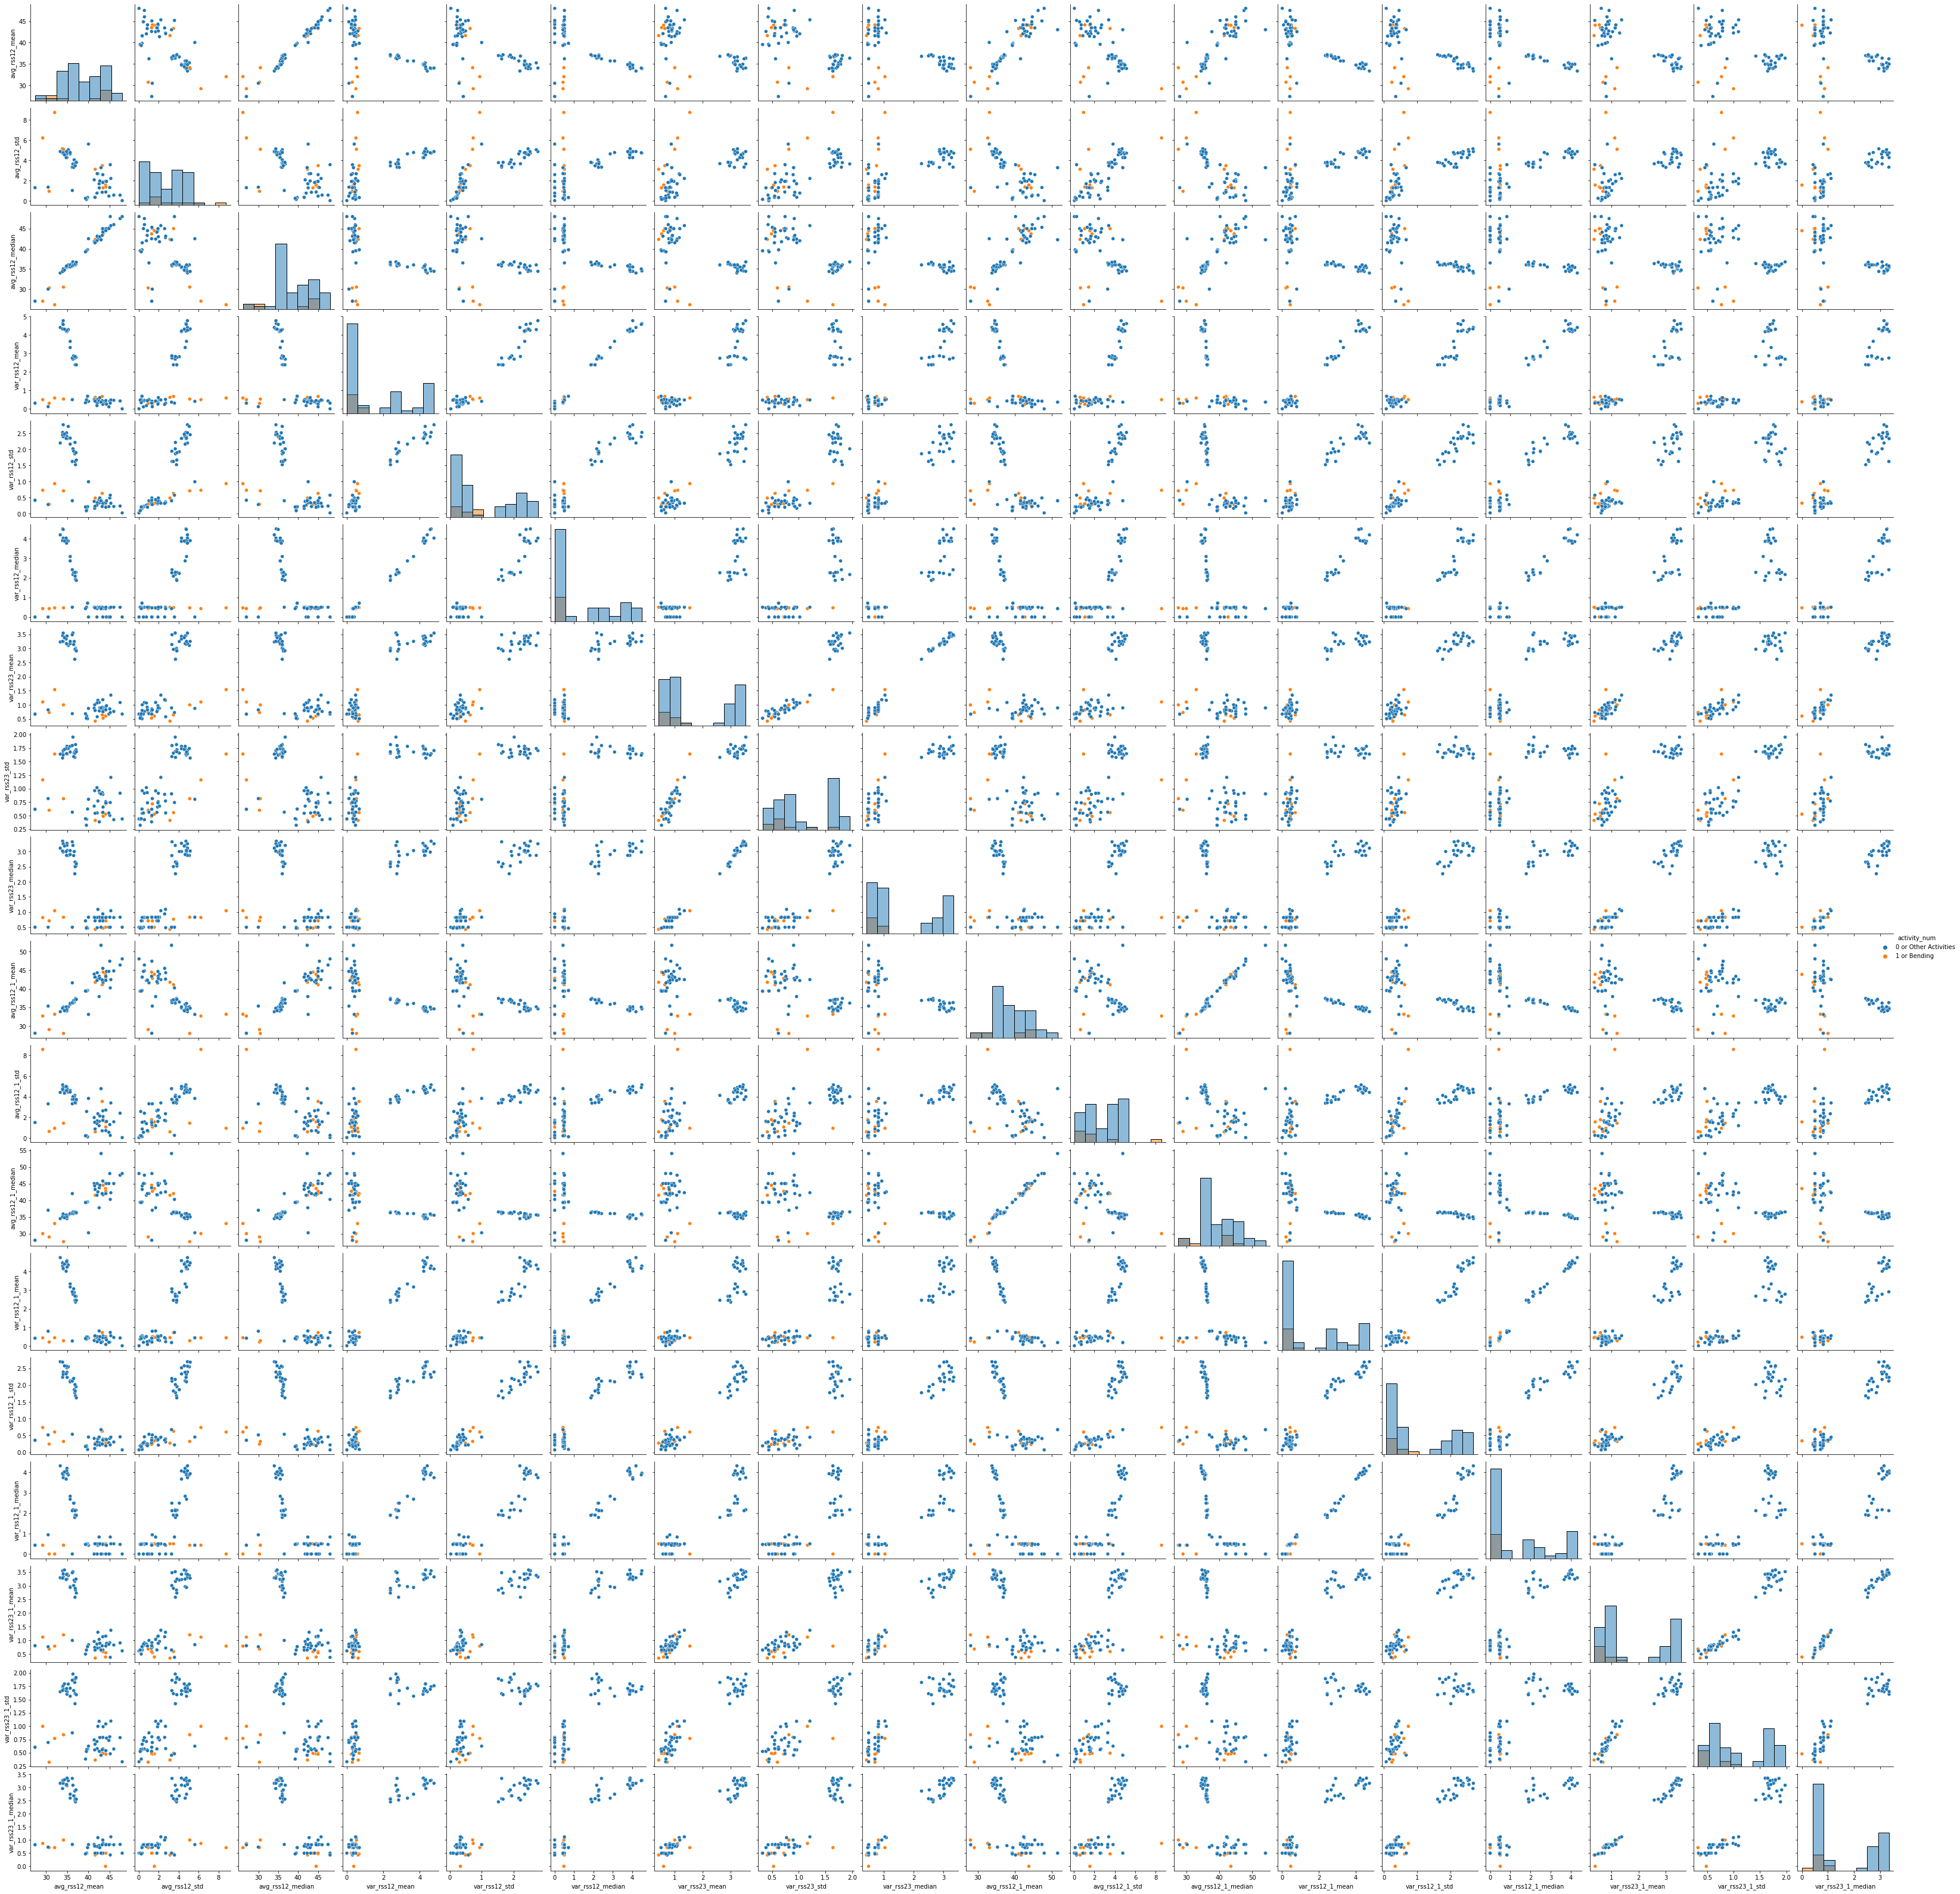

In [6]:
train_data,test_data=split_create_data(2,0)
#train_data.columns
train_data['activity_num']=train_data['activity'].apply(numeric_target)
test_data['activity_num']=test_data['activity'].apply(numeric_target)
g=sns.pairplot(train_data.drop(columns=['activity']),hue='activity_num',diag_kind='hist')
leg = g.axes.flat[0].get_legend()
new_labels = ['0 or Other Activities','1 or Bending']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

### Yes, there is a difference in these scatterplots as compared to the previous scatter plots. As we can see in avg_rss12_mean vs var_rss_12_meadian, both the classes seem to seperate out perfectly using a linear line possibly a non-linear one would do the job perfectly. Moreover for some feature , there is no instance for the rare class which in this case is bending which is also an indicator for well seperated feature sets. So, I expect logistic regression to not give accurate value for betas and be able to converge.

# 2(a)iii RFECV

In [7]:
best_score=[]
best_score_rate=float('-inf')
for l in range(1,21):
    columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    train_data,test_data=split_create_data(l,1)
    train_data['activity_num']=train_data['activity'].apply(numeric_target)
    test_data['activity_num']=test_data['activity'].apply(numeric_target)
    X_train,y_train=train_data.iloc[:,:-2],train_data.iloc[:,-1]
    X_test,y_test=test_data.iloc[:,:-2],test_data.iloc[:,-1]
    model = LogisticRegression (penalty='none',C=np.float('inf'),random_state=32)
    selector = RFECV(model,cv=StratifiedKFold(5))
    selector = selector.fit(X_train, y_train)
    best_score_cv=max(selector.grid_scores_[selector.n_features_])
    #test_error=1-selector.score(X_train,y_train)
    if(best_score_cv>best_score_rate):
        best_score=[]
        best_score.append([best_score_cv,l,selector.n_features_])
        best_score_rate=best_score_cv
    elif(best_score_cv==best_score_rate):
        best_score.append([best_score_cv,l,selector.n_features_])


In [8]:
best_score_obtained,best_l,best_p=best_score[2][0],best_score[2][1],best_score[2][2]
print('One of the best l and p pair are : {},{} with best score validation accuracy={}'.format(best_l,best_p,best_score_obtained))

One of the best l and p pair are : 3,2 with best score validation accuracy=1.0


## The wrong way is to not use cross validation and just use a single split to validate the data. This will obviously lead to overfitting and will not generalize well. The correct way for this is to use k-fold cross validation and in this particular problem to use stratified k-fold since the minority class is very rare and a particular split may have no instances of rare class. What startified k-fold will do is that it will ensure an equal distribution/proportion of rare to majority class across all the splits. Obviously this is the right way and we will follow it throughout our homework.

# 2(a)iv Confusion Metric and other parameters

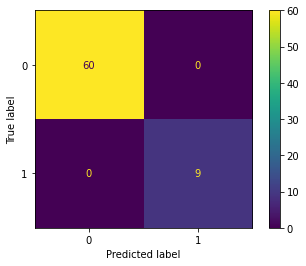

In [9]:
best_score_rate=float('-inf')
columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
train_data,test_data=split_create_data(best_l,1)
train_data['activity_num']=train_data['activity'].apply(numeric_target)
test_data['activity_num']=test_data['activity'].apply(numeric_target)
X_train,y_train=train_data.iloc[:,:-2],train_data.iloc[:,-1]
X_test,y_test=test_data.iloc[:,:-2],test_data.iloc[:,-1]
model = LogisticRegression (penalty='none',C=np.float('inf'),max_iter=300,random_state=32)
selector = RFECV(model,cv=StratifiedKFold(5))
selector = selector.fit(X_train, y_train)
best_score_cv=max(selector.grid_scores_[selector.n_features_])
#test_error=1-selector.score(X_train,y_train)
if(best_score_cv>best_score_rate):
    best_score_rate=best_score_cv
plot_confusion_matrix(selector, X_train, y_train) 

## ROC AUC Curve

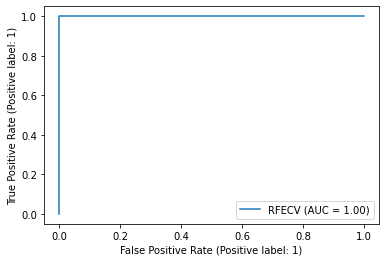

In [10]:
metrics.plot_roc_curve(selector, X_train, y_train)

## Reporting the parameters

In [11]:
log_reg = sm.Logit(y_train, X_train[X_train.columns[selector.support_]]).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.024131
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:           activity_num   No. Observations:                   69
Model:                          Logit   Df Residuals:                       67
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                  0.9377
Time:                        11:13:08   Log-Likelihood:                -1.6651
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.457e-12
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
avg_rss23_mean      13.2437     17.022      0.778      0.437     -20.118      46.606
avg_rss12_

# 2(a) v

Test score=0.9473684210526315
Test error for the following model= 0.052631578947368474


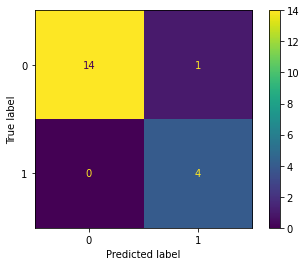

In [13]:
print('Test score={}'.format(selector.score(X_test,y_test)))
print('Test error for the following model= {}'.format(1-selector.score(X_test,y_test)))
plot_confusion_matrix(selector, X_test, y_test) 

### The test accuracy is slightly lower than training cross validation accuracy  which is expected and one of the non-bending activities sets has been misclassified whereas in the train set , the model is perfectly seperable hence leading to  perfect accuracy

# 2(a) vi

## Yes the classes are well seperated as can be seen by the confusion matrix, roc auc curve which covers all area. All the classes have been perfectly classified in the train data which shows the linear seperability. Moreover as is observable in stats model summary, there is a warning that it senses quasi seperation and hence some parameters may not be identified and moreover some value of l are not able to provide any stats model summary due to the perfect seperation as a result of which the model is not able to converge to give accurate predicitons for beta values.

# 2(a) vii

## Yes, the bending class is the imbalanced class in the dataset. As we can see , out of 69 instances in the train set only 9 correspond to bending whereas 60 of them correspond to the other activities class which shows us about the amount of imbalance on the dataset

## First step: Performing under and over sampling and selecting best o and u values 

In [14]:
# best_score_rate=float('-inf')
# columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
# train_data,test_data=split_create_data(best_l,1)
# train_data['activity_num']=train_data['activity'].apply(numeric_target)
# test_data['activity_num']=test_data['activity'].apply(numeric_target)
# X_train,y_train=train_data.iloc[:,:-2],train_data.iloc[:,-1]
# X_test,y_test=test_data.iloc[:,:-2],test_data.iloc[:,-1]
u_val,o_val=-1,-1
best_score_till_now=float('-inf')
s=np.arange(0.3,1,0.1)
for o in s:
    for u in s:
        model = LogisticRegression(penalty='none',C=np.float('inf'),random_state=32)
        over = SMOTE(sampling_strategy=o)
        under = RandomUnderSampler(sampling_strategy=u)
        selector = RFECV(model,cv=StratifiedKFold(5))
        steps = [('over', over), ('under', under)]
        pipeline = Pipeline(steps=steps)
        try:
            X_train_SMOTE, y_train_SMOTE = pipeline.fit_resample(X_train, y_train)
            selector = selector.fit(X_train_SMOTE, y_train_SMOTE)
            best_score_cv=max(selector.grid_scores_[selector.n_features_])
            if(best_score_cv>=best_score_till_now):
                u_val=u
                o_val=o
                best_score_till_now=best_score_cv
        except:
            continue

In [15]:
best_score_till_now,u_val,o_val

(1.0, 0.9000000000000001, 0.9000000000000001)

## Second step : running the model again with the best o and v value and finding the confusion matrix and auc roc curve

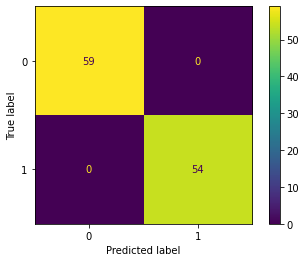

In [15]:
model = LogisticRegression(penalty='none',C=np.float('inf'),random_state=32)
over = SMOTE(sampling_strategy=o_val)
under = RandomUnderSampler(sampling_strategy=u_val)
selector = RFECV(model,cv=StratifiedKFold(5))
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_train_SMOTE, y_train_SMOTE = pipeline.fit_resample(X_train, y_train)
selector = selector.fit(X_train_SMOTE, y_train_SMOTE)
plot_confusion_matrix(selector, X_train_SMOTE, y_train_SMOTE) 

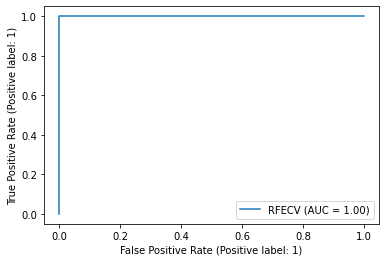

In [17]:
metrics.plot_roc_curve(selector, X_train, y_train)

# 2(b)

## 2(b)i L-1 regularized linear regression

### Normalizing the features

In [18]:
def normalize(X_train,X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled

### Finding the best l

In [19]:
# from sklearn import pipeline
# best_score=[]
# best_score_rate=float('-inf')
# for l in range(1,21):
#     columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
#     train_data,test_data=split_create_data(l,1)
#     train_data['activity_num']=train_data['activity'].apply(numeric_target)
#     test_data['activity_num']=test_data['activity'].apply(numeric_target)
#     X_train,y_train=train_data.iloc[:,:-2],train_data.iloc[:,-1]
#     X_test,y_test=test_data.iloc[:,:-2],test_data.iloc[:,-1]
#     scaler = MinMaxScaler()
#     selector = feature_selection.RFE(model)
#     #X_train,X_test=normalize(X_train,X_test)
#     #params=dict(solver=['liblinear'])
#     model = LogisticRegression (penalty='l1',random_state=32,solver='liblinear')
#     pipe_params = [('feat_selection',selector),('std_scaler', scaler), ('clf', model)]
#     pipe = pipeline.Pipeline(pipe_params)
#     param_grid=dict(clf__C=[1, 10, 100, 1000])
#     clf = GridSearchCV(pipe, param_grid,cv=5)
#     clf.fit(X_train, y_train)
#     best_score_cv=clf.cv_results_['mean_test_score']
#     #test_error=1-selector.score(X_train,y_train)
#     best_score_cv=best_score_cv.mean()
#     if(best_score_cv>best_score_rate):
#         best_score=[]
#         best_score.append([best_score_cv,l,clf.best_params_])
#         best_score_rate=best_score_cv
#     elif(best_score_cv==best_score_rate):
#         best_score.append([best_score_cv,l,clf.best_params_])

In [20]:
best_score=[]
best_score_rate=float('-inf')
for l in range(1,21):
    columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    train_data,test_data=split_create_data(l,1)
    train_data['activity_num']=train_data['activity'].apply(numeric_target)
    test_data['activity_num']=test_data['activity'].apply(numeric_target)
    X_train,y_train=train_data.iloc[:,:-2],train_data.iloc[:,-1]
    X_test,y_test=test_data.iloc[:,:-2],test_data.iloc[:,-1]
    X_train,X_test=normalize(X_train,X_test)
    #params=dict(solver=['liblinear'])
    clf = LogisticRegressionCV(penalty='l1',random_state=32,solver='liblinear')
    clf.fit(X_train, y_train)
    #print(clf.C_)
    best_score_cv=max(clf.scores_[1].mean(axis=0))
    #test_error=1-selector.score(X_train,y_train)
    #best_score_cv=best_score_cv.mean()
    if(best_score_cv>best_score_rate):
        best_score=[]
        best_score.append([best_score_cv,l,clf.C_])
        best_score_rate=best_score_cv
    elif(best_score_cv==best_score_rate):
        best_score.append([best_score_cv,l,clf.C_])

In [21]:
#print(best_score[0][2]['clf__C'])
best_l,best_C=best_score[0][1],best_score[0][2][0]
#best_l=best_score[0][1]

### Running the model on test data and plotting the confusion matrix

The test accuracy=0.9473684210526315
Test error for the following model= 0.052631578947368474


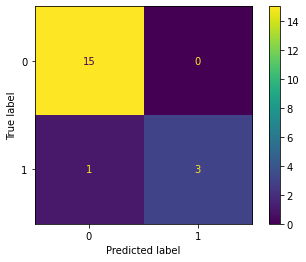

In [24]:
columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
train_data,test_data=split_create_data(best_l,1)
train_data['activity_num']=train_data['activity'].apply(numeric_target)
test_data['activity_num']=test_data['activity'].apply(numeric_target)
X_train,y_train=train_data.iloc[:,:-2],train_data.iloc[:,-1]
X_test,y_test=test_data.iloc[:,:-2],test_data.iloc[:,-1]
X_train,X_test=normalize(X_train,X_test)
#params=dict(clf__C=[best_C])
clf = LogisticRegressionCV(penalty='l1',random_state=32,solver='liblinear',Cs=[best_C])
#clf = GridSearchCV(model, params, cv=5)
clf.fit(X_train, y_train)
print('The test accuracy={}'.format(clf.score(X_test,y_test)))
print('Test error for the following model= {}'.format(1-clf.score(X_test,y_test)))
plot_confusion_matrix(clf, X_test, y_test) 

# 2(b) ii

### Both the models performed equally on the test set but according to me running the l1 regularization was easier and took less time ie more efficient computationally than p-feature selection. Moreover in p-feature selection, we had to explicitly use the reduced feature set for training whereas the l1-penalized method automatically does the job for us !!

# 2(c) i Multinomial regression

In [25]:
def multinomial_target(y):
    print(np.shape(y))
    label_encoder = LabelEncoder().fit(y)
    target = label_encoder.transform(y)
    return target

In [26]:
best_score=[]
best_score_rate=float('-inf')
for l in range(1,21):
    columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    train_data,test_data=split_create_data(l,1)
    X_train,y_train=train_data.iloc[:,:-1],train_data.iloc[:,-1]
    X_test,y_test=test_data.iloc[:,:-1],test_data.iloc[:,-1]
    #print(y_train,y_test)
    if(l==1):
        label_encoder = LabelEncoder().fit(y_train)
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    X_train,X_test=normalize(X_train,X_test)
    #print(y_train,y_test)
    #scaler = MinMaxScaler()
    #selector = feature_selection.RFE(model)
    #X_train,X_test=normalize(X_train,X_test)
    #params=dict(solver=['liblinear'])
    clf = LogisticRegressionCV(penalty='l1',solver='saga',random_state=32,multi_class='multinomial')
    #pipe_params = [('feat_selection',selector),('std_scaler', scaler), ('clf', model)]
    #pipe = pipeline.Pipeline(pipe_params)
    #param_grid=dict(clf__C=[1, 10, 100, 1000])
    #clf = GridSearchCV(pipe, param_grid,cv=5)
    clf.fit(X_train, y_train)
    #print(clf.scores_)
    best_score_cv=max(clf.scores_[1].mean(axis=0))
    #test_error=1-selector.score(X_train,y_train)
    best_score_cv=best_score_cv.mean()
    if(best_score_cv>best_score_rate):
        best_score=[]
        best_score.append([best_score_cv,l,clf.C_.mean()])
        best_score_rate=best_score_cv
    elif(best_score_cv==best_score_rate):
        best_score.append([best_score_cv,l,clf.C_.mean()])

In [27]:
#best_l=best_score[0][1]
best_l,best_C=best_score[0][1],best_score[0][2]
#best_score

In [28]:
columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
train_data,test_data=split_create_data(best_l,1)
X_train,y_train=train_data.iloc[:,:-1],train_data.iloc[:,-1]
X_test,y_test=test_data.iloc[:,:-1],test_data.iloc[:,-1]
#print(y_train,y_test)
#label_encoder = LabelEncoder().fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
X_train,X_test=normalize(X_train,X_test)
#print(y_train,y_test)
#scaler = MinMaxScaler()
#selector = feature_selection.RFE(model)
#X_train,X_test=normalize(X_train,X_test)
#params=dict(solver=['liblinear'])
clf = LogisticRegressionCV(penalty='l1',random_state=32,solver='liblinear',Cs=[best_C])
#pipe_params = [('std_scaler', scaler), ('clf', model)]
#pipe = pipeline.Pipeline(pipe_params)
clf.fit(X_train, y_train)
#print(clf.cv_results_)
print('Test Score={}'.format(clf.score(X_test,y_test)))
print('Test Error for the multinomial regression model = {}'.format(1-clf.score(X_test,y_test)))

Test Score=0.9473684210526315
Test Error for the multinomial regression model = 0.052631578947368474


### Confusion matrix and AUC-ROC Curve for multiclass regression

### Confusion matrix plotted 

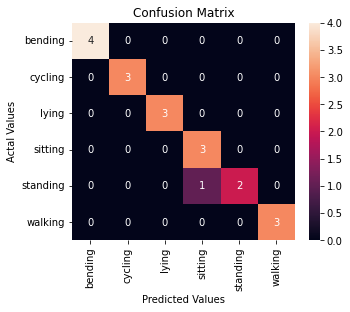

In [33]:
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
conf_matrix=pd.DataFrame(conf,columns=le_name_mapping.keys(),index=le_name_mapping.keys())
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
#print(y_test,y_pred)
#le_name_mapping

## ROC AUC Curve

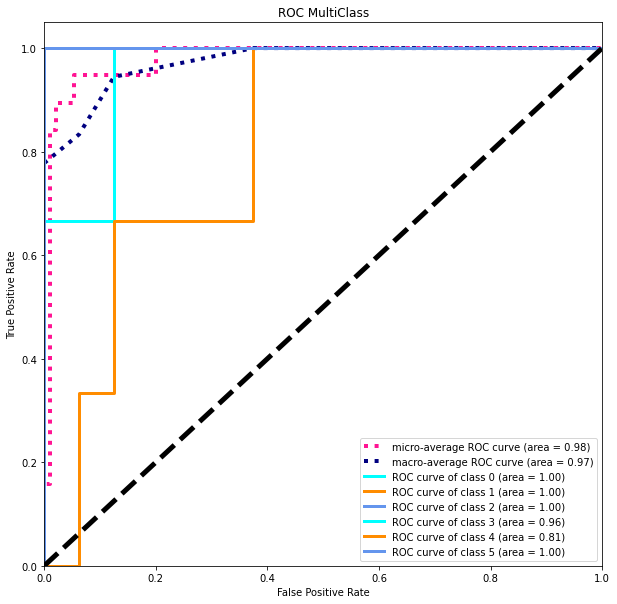

In [35]:
n_classes = 6

y_score = clf.fit(X_train, y_train).decision_function(X_test)
y_test = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
# Compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        linewidth=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
#fig = gcf()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot([0, 1], [0, 1], "k--", linewidth=5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC MultiClass")
plt.legend(loc="lower right")

# 2(c)ii

## Gaussian Naive Bayes

In [51]:
best_score=[]
best_score_rate=float('-inf')
for l in range(1,21):
    columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    train_data,test_data=split_create_data(l,1)
    X_train,y_train=train_data.iloc[:,:-1],train_data.iloc[:,-1]
    X_test,y_test=test_data.iloc[:,:-1],test_data.iloc[:,-1]
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    gnb = GaussianNB()
    #gnb.fit(X_train,y_train)
    #best_score_cv=gnb.score(X_train,y_train)
    best_score_cv=cross_val_score(gnb, X_train, y_train, cv=5).mean()
    if(best_score_cv>best_score_rate):
        best_score=[]
        best_score.append([best_score_cv,l])
        best_score_rate=best_score_cv
    elif(best_score_cv==best_score_rate):
        best_score.append([best_score_cv,l])

In [52]:
best_l=best_score[0][1]

Test score= 0.8947368421052632
Test Error for the multinomial regression model = 0.10526315789473684


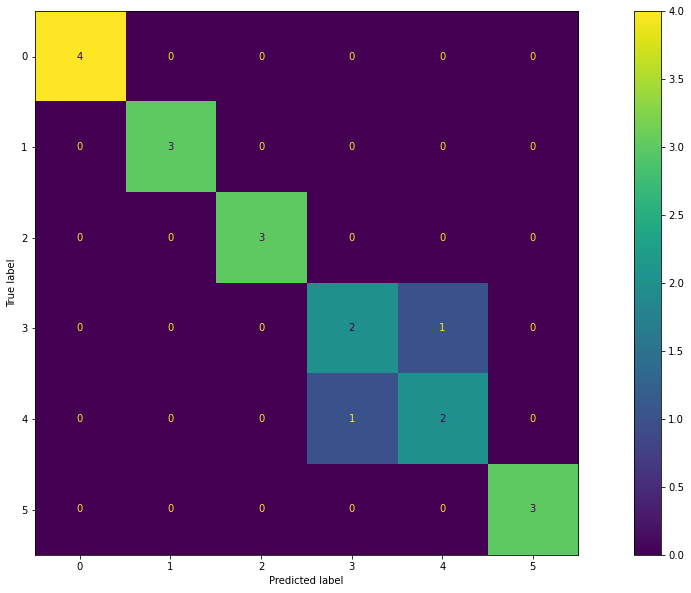

In [53]:
columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
train_data,test_data=split_create_data(best_l,1)
X_train,y_train=train_data.iloc[:,:-1],train_data.iloc[:,-1]
X_test,y_test=test_data.iloc[:,:-1],test_data.iloc[:,-1]
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
gnb = GaussianNB()
gnb.fit(X_train,y_train)
print('Test score= {}'.format(gnb.score(X_test,y_test)))
print('Test Error for the multinomial regression model = {}'.format(1-gnb.score(X_test,y_test)))
plot_confusion_matrix(gnb, X_test, y_test)

## Multinomial priors

In [45]:
best_score=[]
best_score_rate=float('-inf')
for l in range(1,21):
    columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    train_data,test_data=split_create_data(l,1)
    X_train,y_train=train_data.iloc[:,:-1],train_data.iloc[:,-1]
    X_test,y_test=test_data.iloc[:,:-1],test_data.iloc[:,-1]
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    gnb = MultinomialNB()
    #gnb.fit(X_train,y_train)
    best_score_cv=cross_val_score(gnb, X_train, y_train, cv=5).mean()
    if(best_score_cv>best_score_rate):
        best_score=[]
        best_score.append([best_score_cv,l])
        best_score_rate=best_score_cv
    elif(best_score_cv==best_score_rate):
        best_score.append([best_score_cv,l])

In [46]:
best_l=best_score[0][1]

Test score= 0.9473684210526315
Test Error for the multinomial regression model = 0.052631578947368474


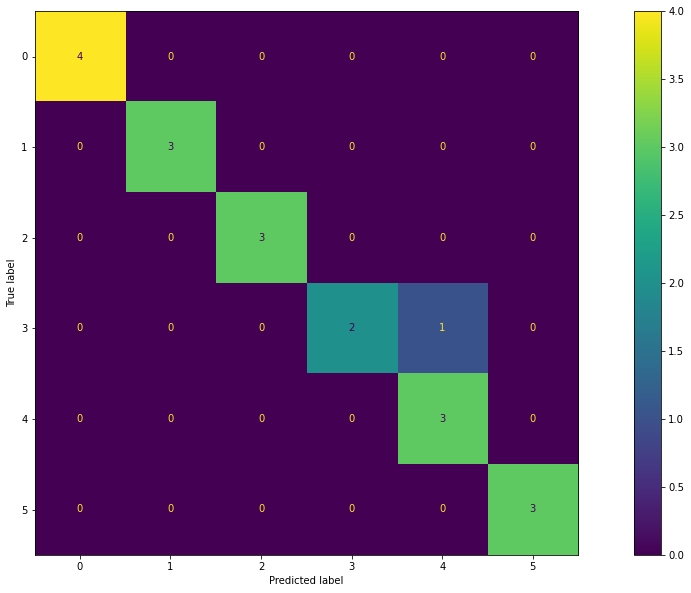

In [49]:
columns_req=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
train_data,test_data=split_create_data(best_l,1)
X_train,y_train=train_data.iloc[:,:-1],train_data.iloc[:,-1]
X_test,y_test=test_data.iloc[:,:-1],test_data.iloc[:,-1]
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
gnb = MultinomialNB()
gnb.fit(X_train,y_train)
print('Test score= {}'.format(gnb.score(X_test,y_test)))
print('Test Error for the multinomial regression model = {}'.format(1-gnb.score(X_test,y_test)))
plot_confusion_matrix(gnb, X_test, y_test) 


### As we can see, multinomial priors NB performs better than gaussian NB on the test set and so is the better method to be applied

## 2(c) iii: According to the test errors for all in the multiclass regression problem, the multinomial logistic regression and the multinomial naive bayes  gives the best test accuracy and seems to be the best choice. Both have there own sets of assumptions which may lead to the ultimate decision of whether to use Multinomial NB or logistic regression l1-penalized. According to me, if the sets of features was very large like in many of the higher l-values, a l1-penalized logistic regression method would be very suitable and also in real world scenarios , the features are almost always associated with each other and the naive bayes may suffer from the feature independence assumption. But if we talk about this problem, based on the results , both seam to be a good fit.

# 3. solution to 4.8.3

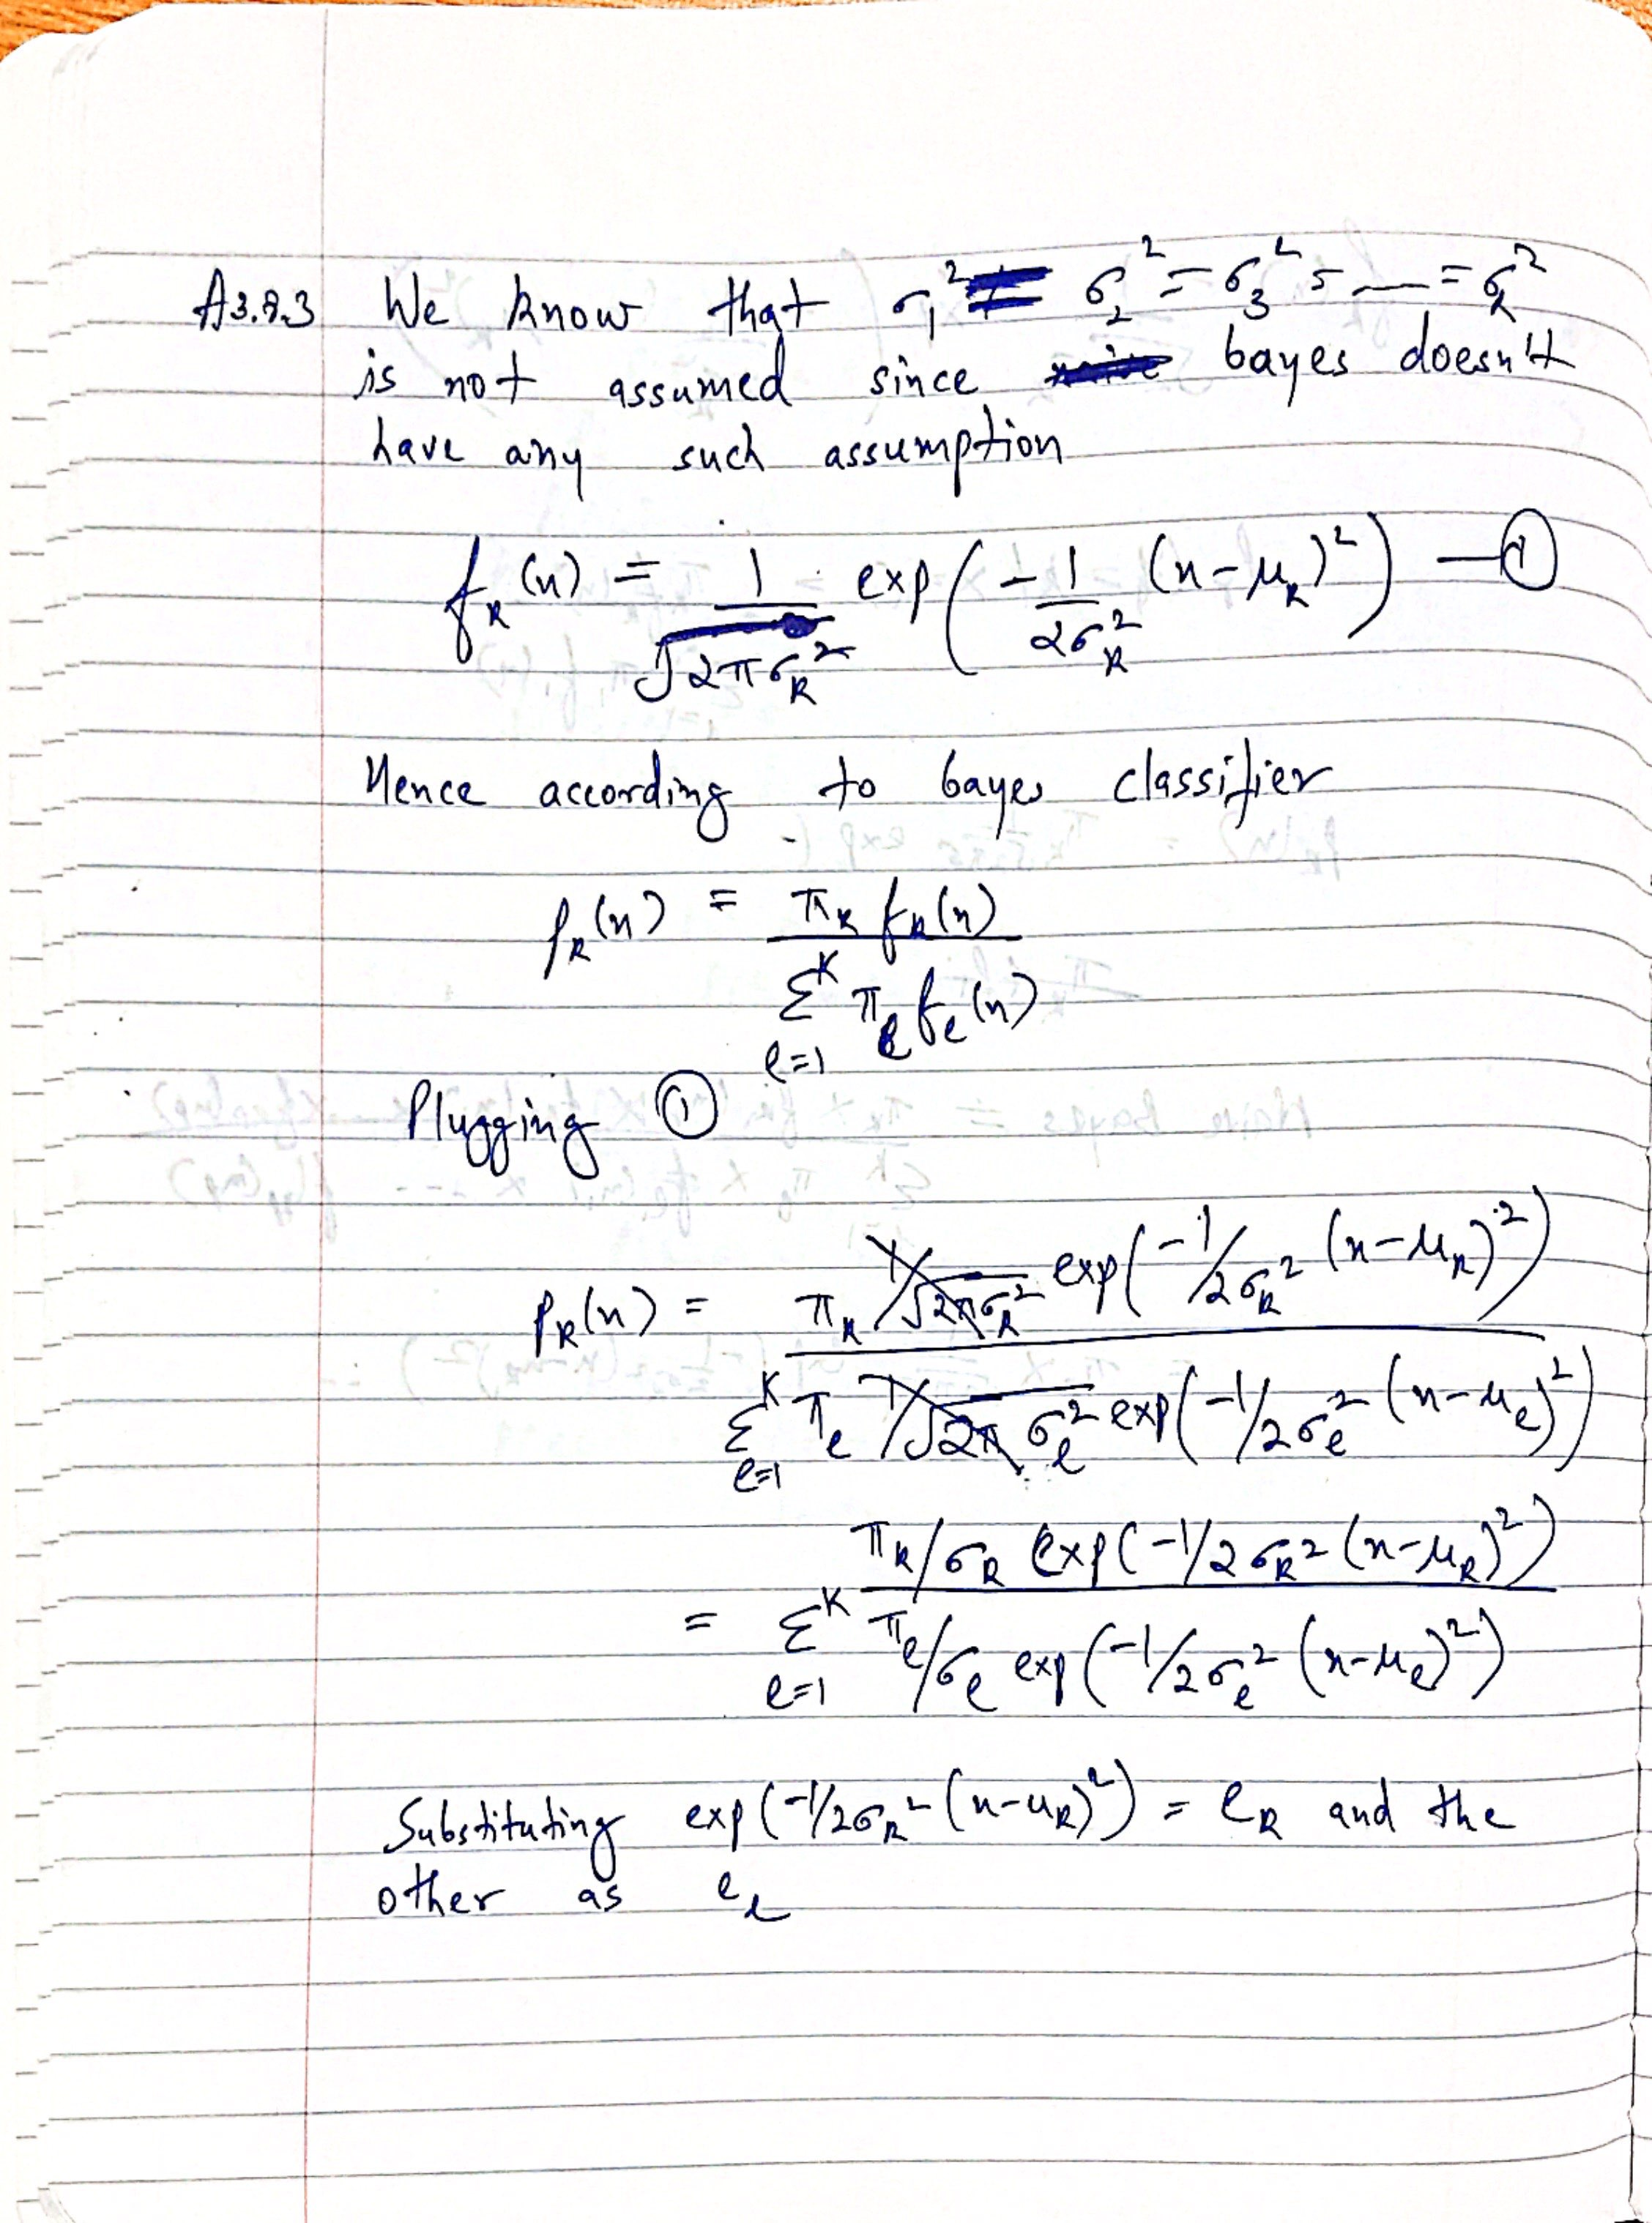

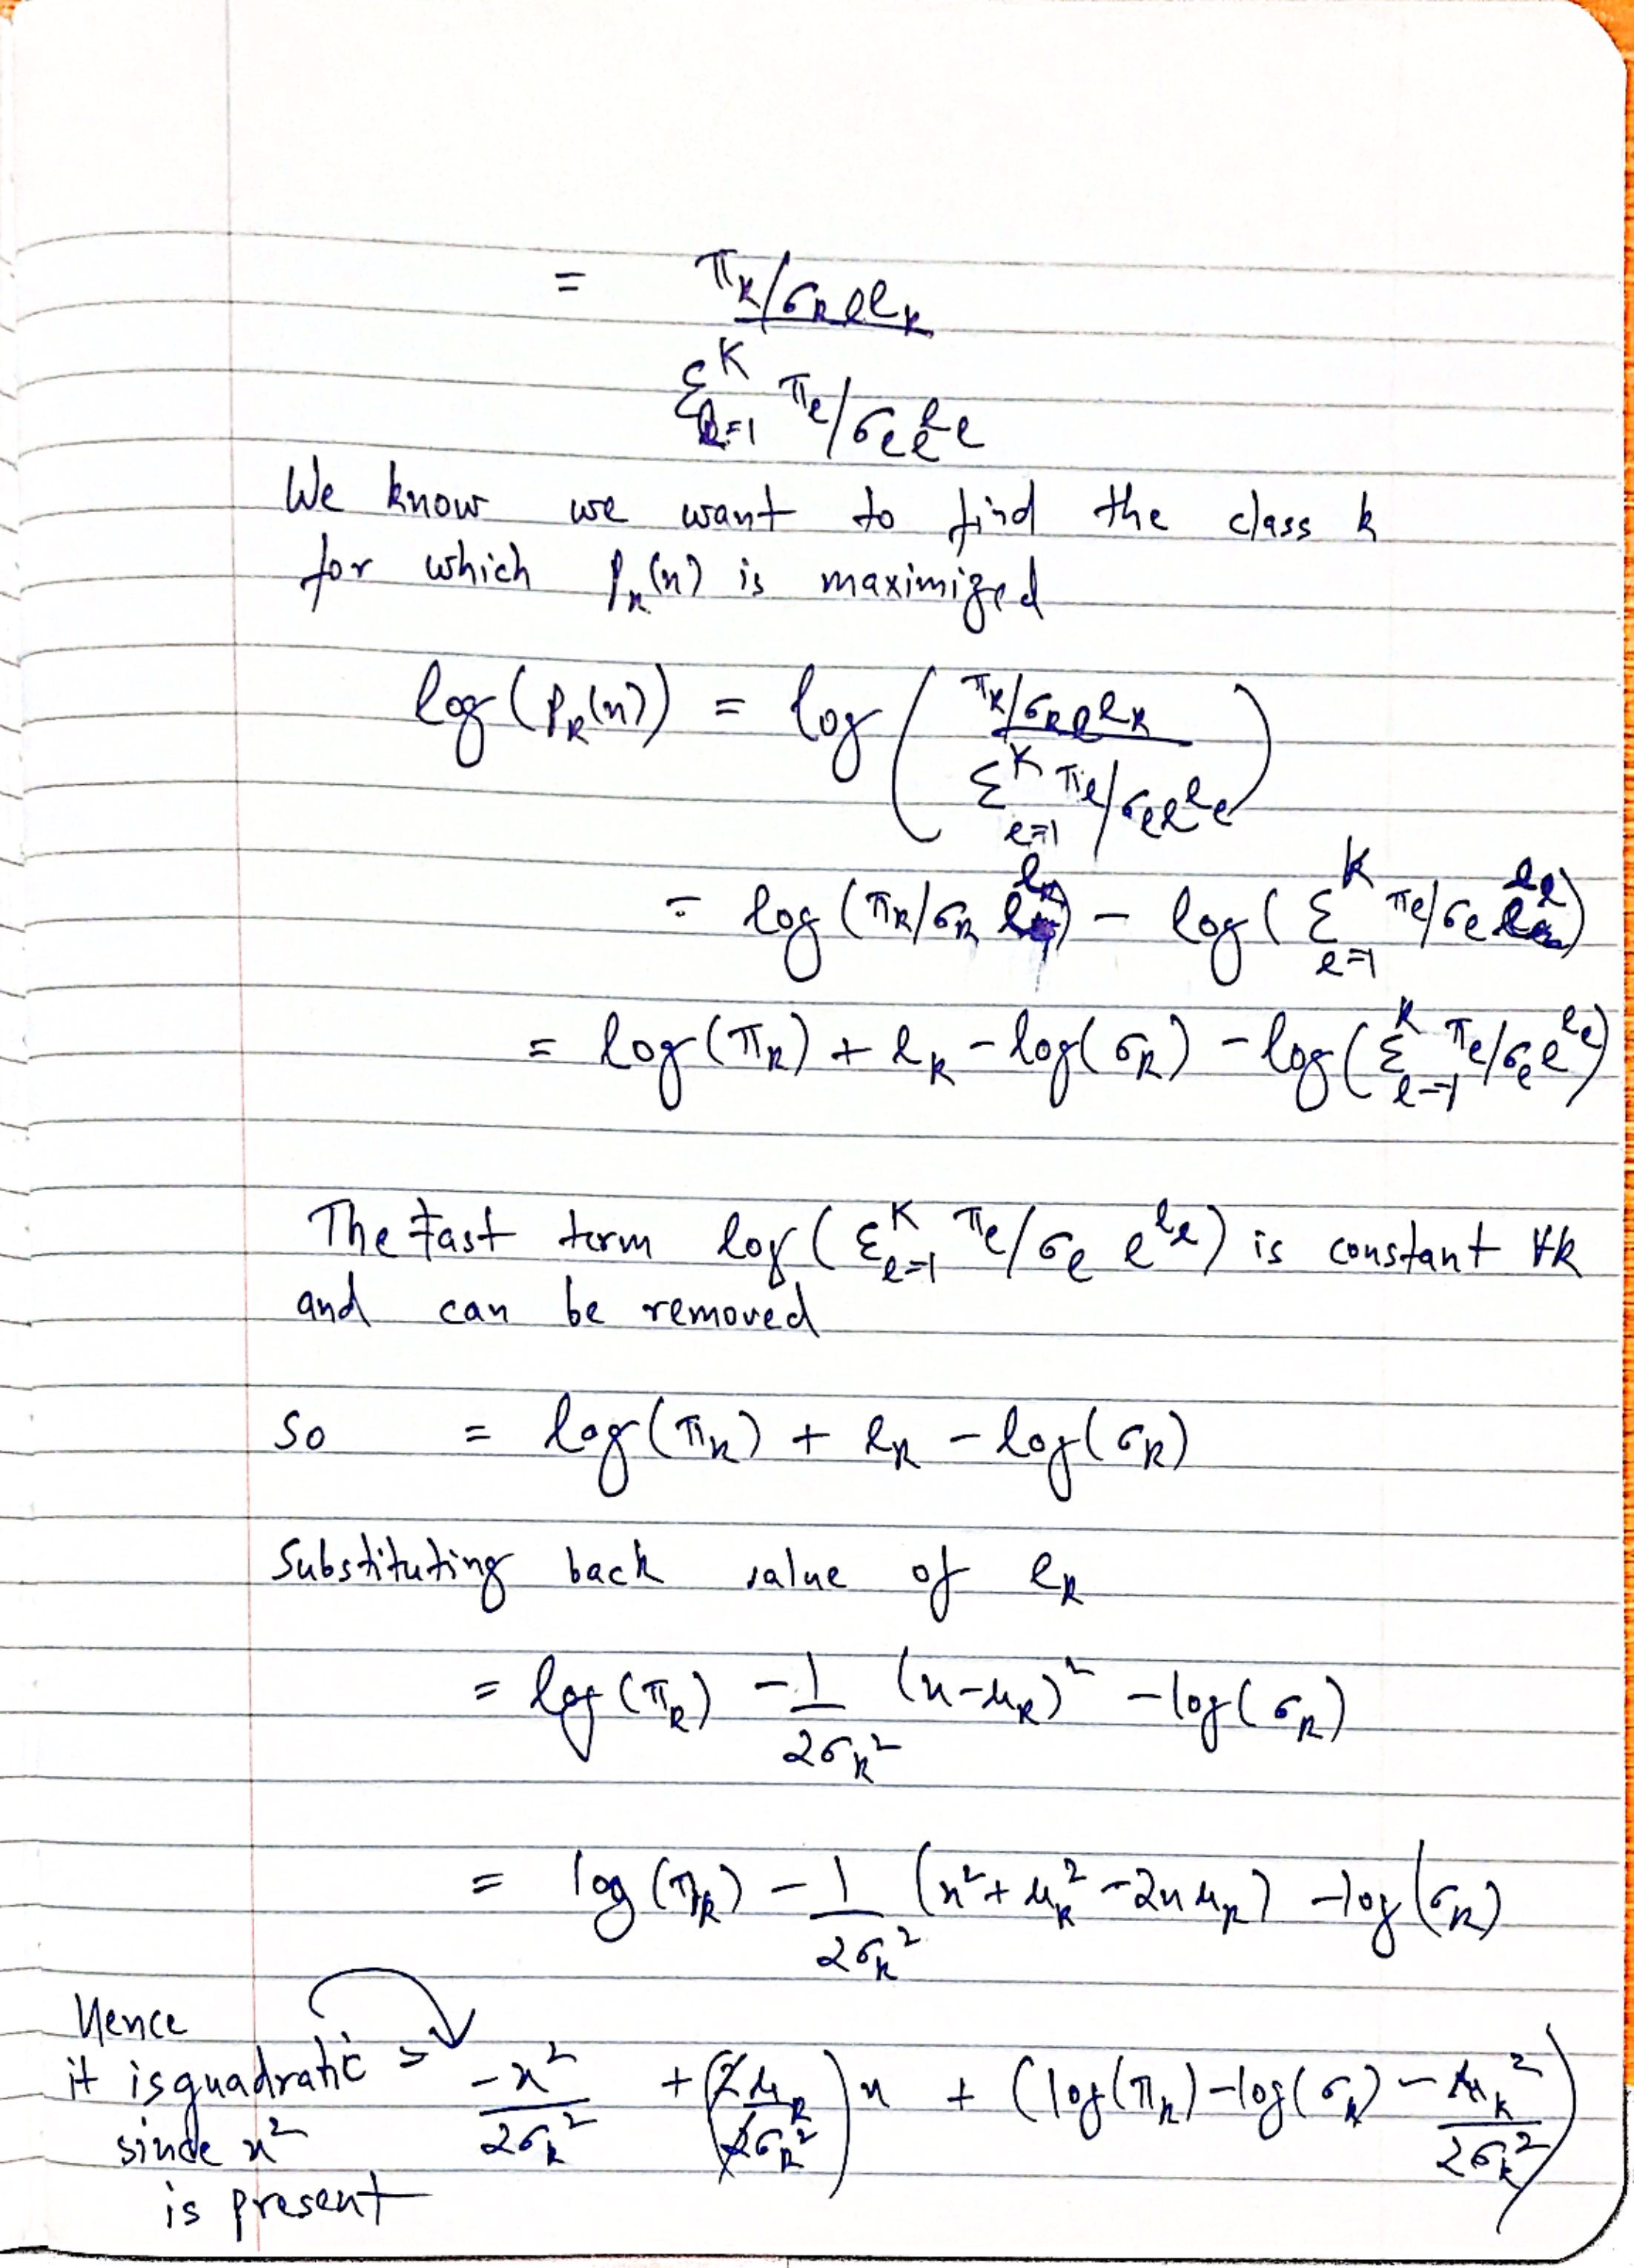

In [54]:
from IPython.display import Image
for img in ["Ans_3.8.3.1.jpg","Ans_3.8.3.2.jpg"]:
    display(Image(img))

# 4. 4.8.7

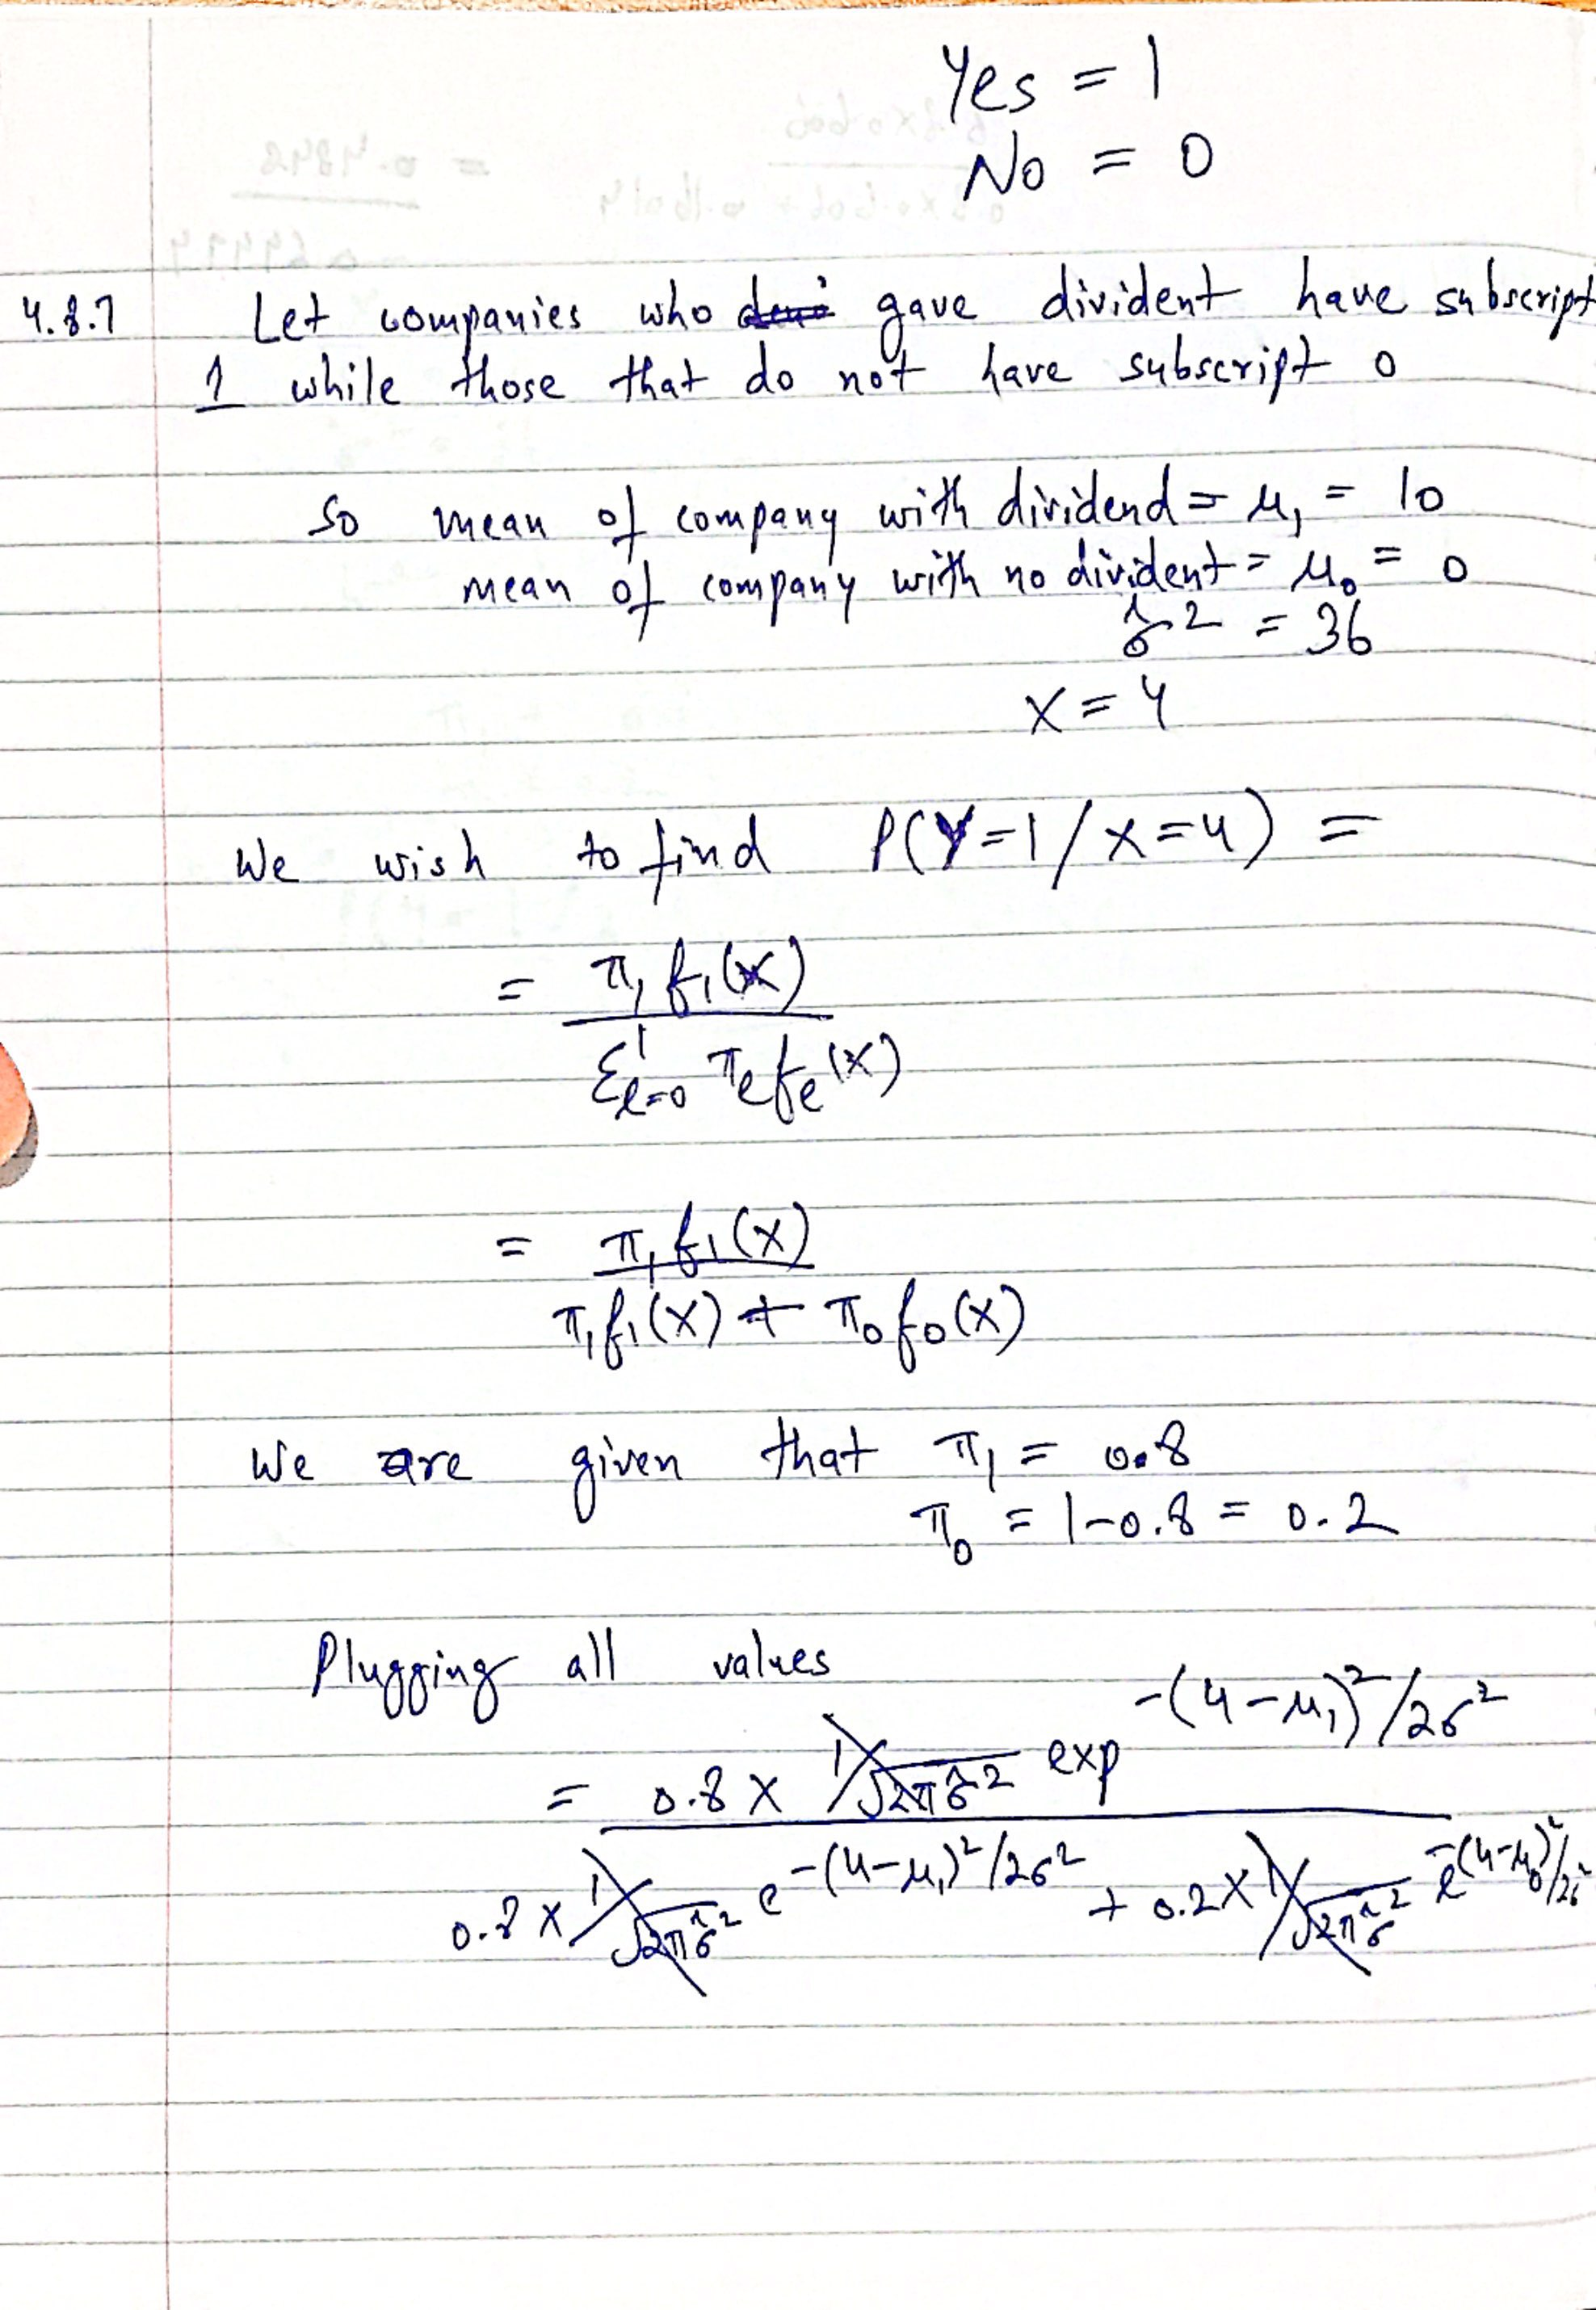

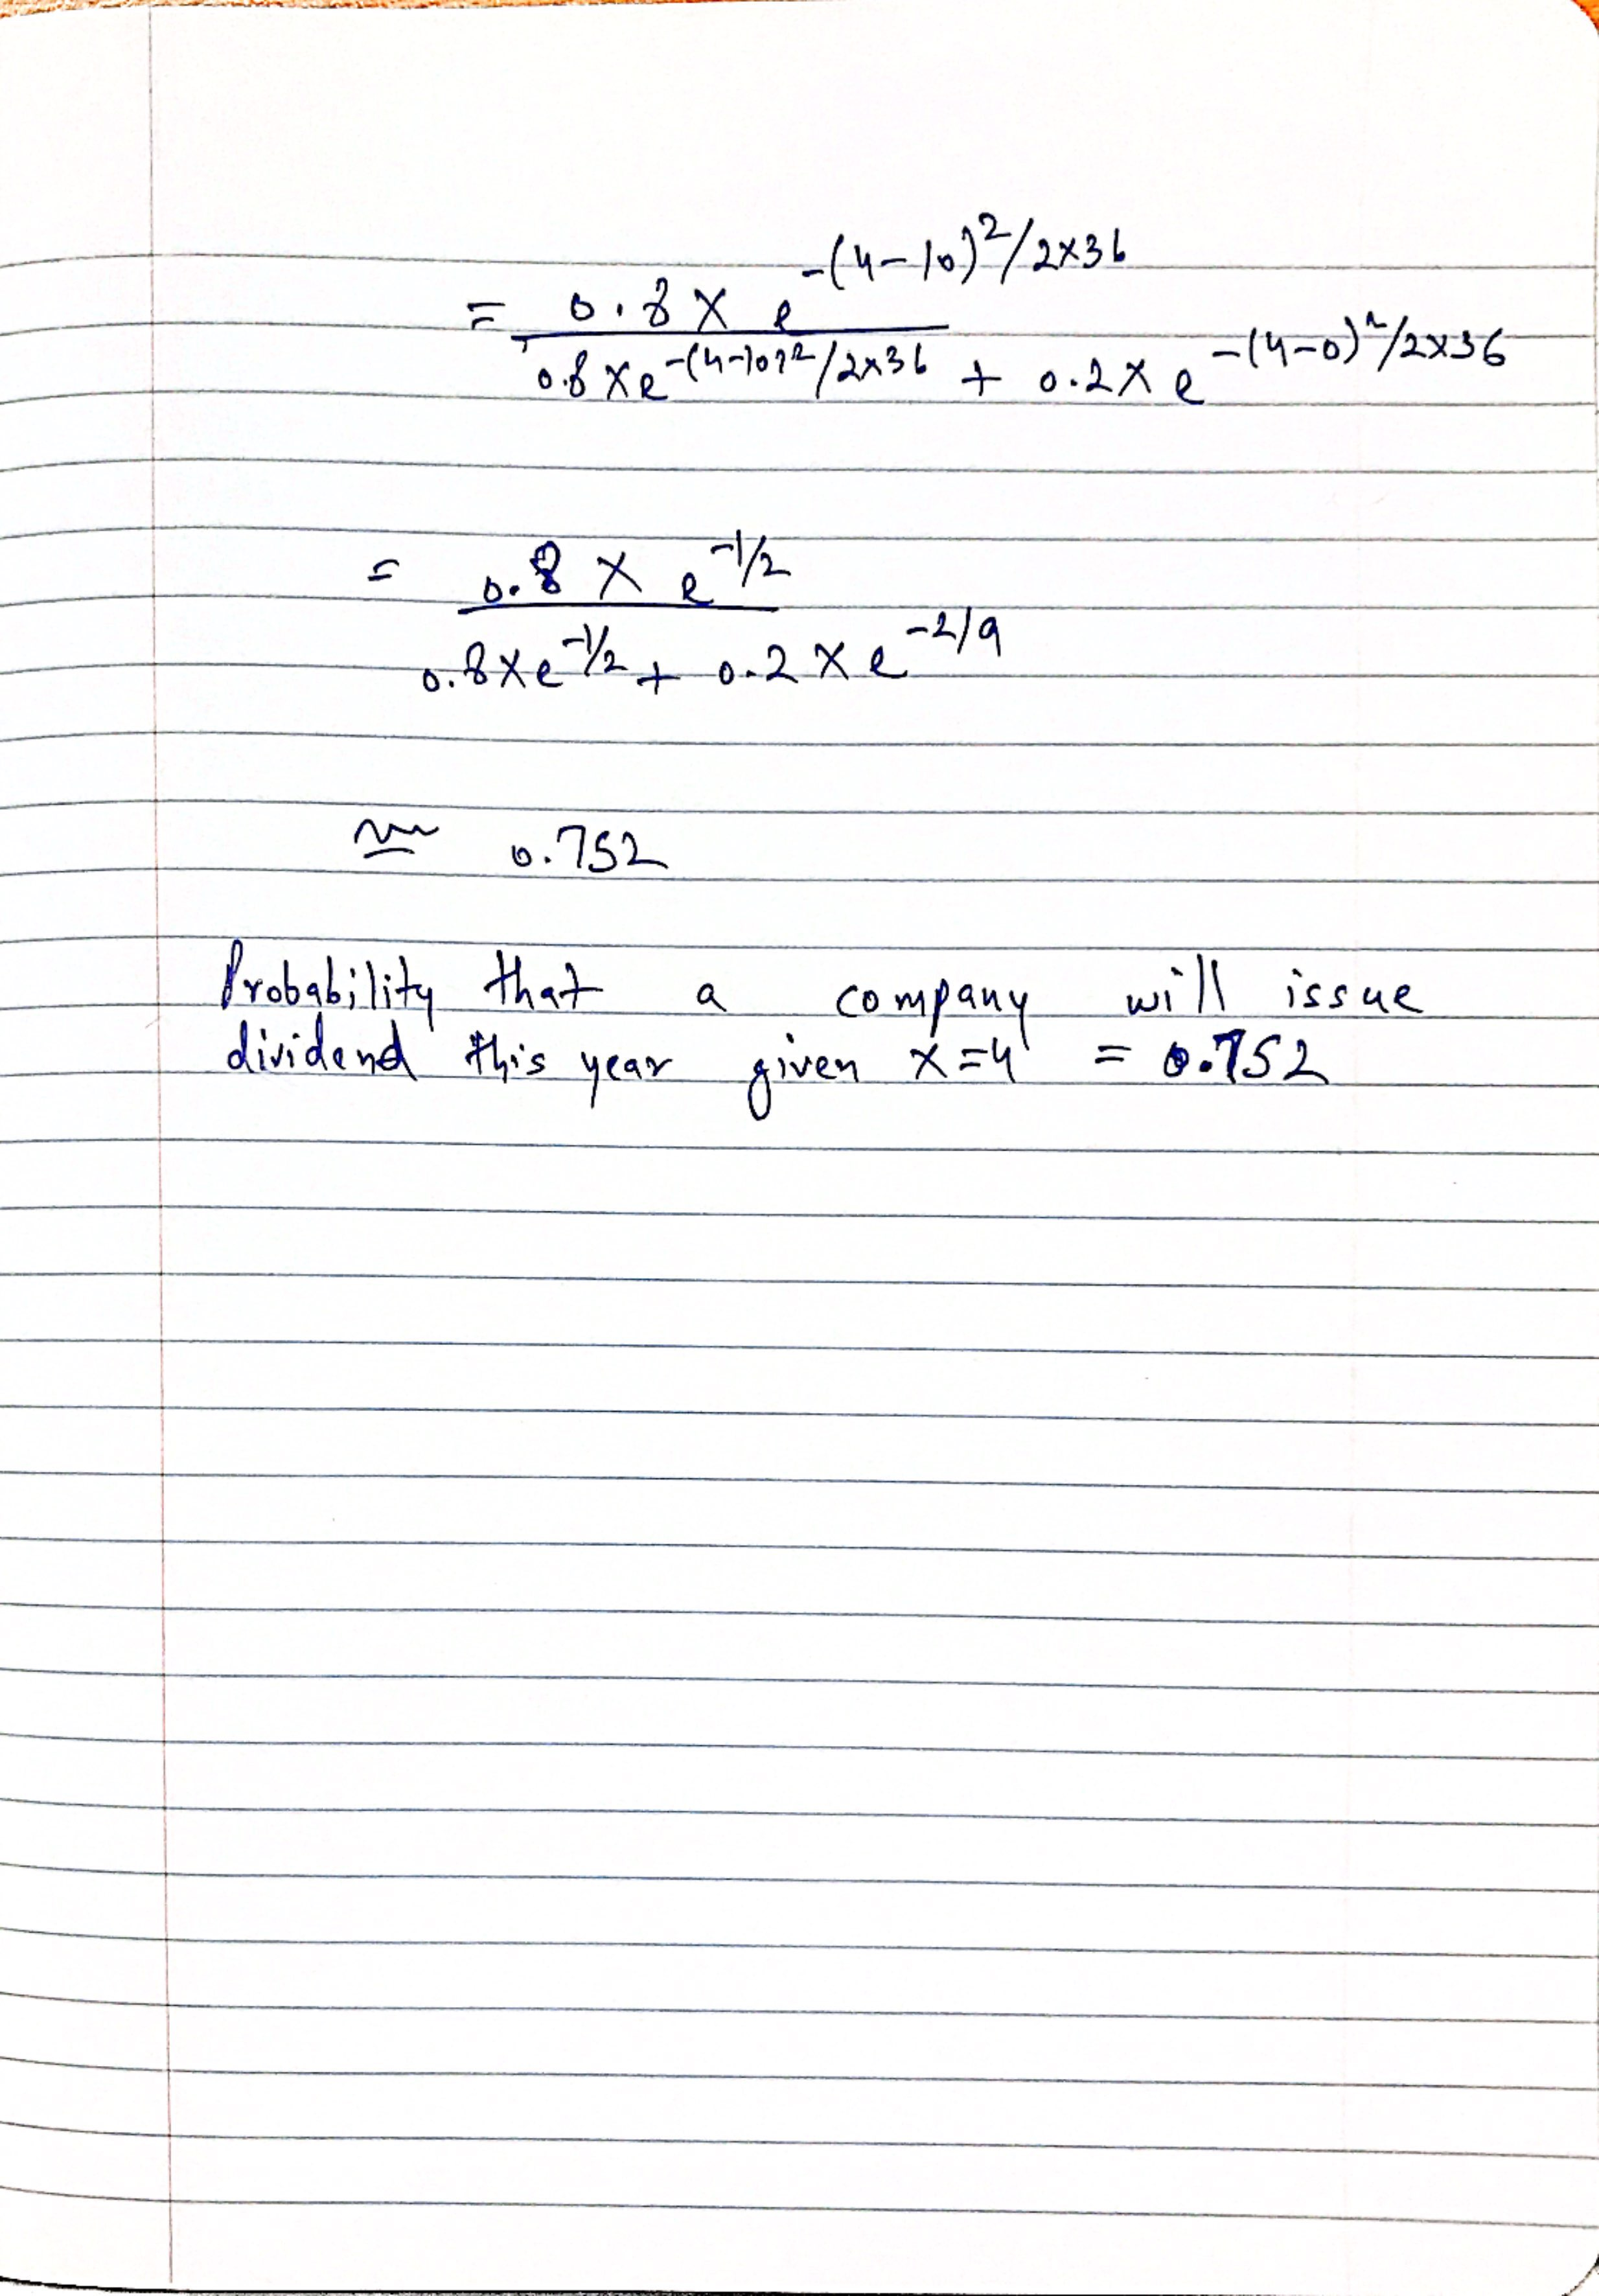

In [55]:
from IPython.display import Image
for img in ["Ans_3.8.7.1.jpg","Ans_3.8.7.2.jpg"]:
    display(Image(img))

# References
## 1.https://michael-fuchs-python.netlify.app/2019/11/15/multinomial-logistic-regression/
## 2. https://piazza.com/class/ky97c8hbyy0sm?cid=585
## 3. https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html